/tmp/ipython-input-12-2117214340.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = adjacency_matrix(G)


Edges to cut: [(21, 19)]


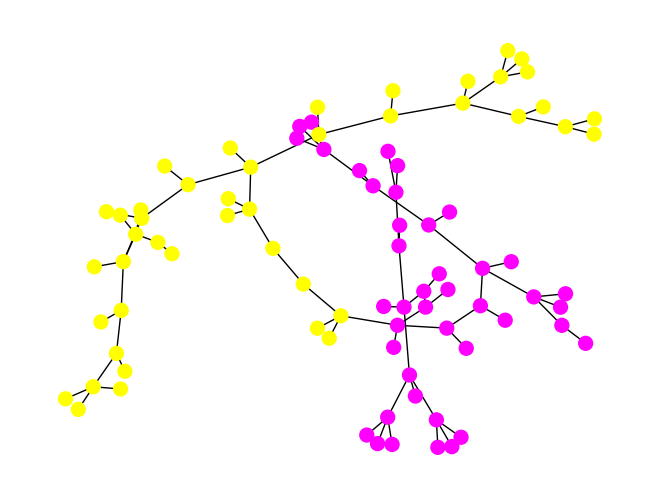

In [ ]:
#! pip install xyz2graph
#!pip install scipy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from xyz2graph import MolGraph
from networkx import adjacency_matrix
from scipy.sparse import csr_matrix

def MakeAdjecencyMatrix(File_Path):
  mg = MolGraph()
  mg.read_xyz(File_Path)
  G = mg.to_networkx()
  A = adjacency_matrix(G)
  return(A)                   # Provides a Adj_Matrix to work with

def cut_ratio(Adj_Matrix, order, k):            # Assigns Cut score
    n = Adj_Matrix.shape[0]                     # Gets Number of Nodes
    edge_boundary = 0                           # Counter for number of edges to cut
    for i in range(k + 1):
        for j in range(k + 1, n):               # Counts number of edges between groups
            edge_boundary += Adj_Matrix[order[i], order[j]]
    denominator = min(k + 1, n - k - 1)         # Keeps balance of groups
    return edge_boundary / denominator

def spectral_cut2(A_dense):
    n = A_dense.shape[0]                        # Gets Number of Nodes
    degrees = A_dense.sum(axis=1)               # List of Degree of each node
    D = np.diag(degrees)                        # Makes diagonal matrix from Degree
    L = D - A_dense                             # Makes Lapacian Matrix
    w, v = np.linalg.eigh(L)                    # finds eigenvalues and eigenvectors
    order = np.argsort(v[:, np.argsort(w)[1]])  # Find second smallest eigenvector

    phi = np.zeros(n - 1)                       # List for Cut Scores
    for k in range(n - 1):                      # gets cut score for each node
      phi[k] = cut_ratio(A_dense, order, k)
    imin = np.argmin(phi)                       # finds node with smallest cut score

    return order[:imin + 1], order[imin + 1:],order,imin   # points before and after the cut point

def get_cut_edges(adj_matrix, order, imin):
    left = order[:imin + 1]
    right = order[imin + 1:]
    cut_edges = []
    for i in left:
        for j in right:
            if adj_matrix[i, j] != 0:         # From the cut point checks for edges
                cut_edges.append((i, j))
    return cut_edges

def viz_cut(G, s, pos=None, node_size=100, with_labels=False):
    n = G.number_of_nodes()
    assign = np.zeros(n)
    assign[s] = 1
    if pos is None:
        pos = nx.spring_layout(G)
    nx.draw(G, node_color=assign, pos=pos, with_labels=with_labels,
            cmap='spring', node_size=node_size, font_color='k')
    plt.show()




File_Path = "/content/4d2g_2.xyz"          # Used to make graph
Matrix = MakeAdjecencyMatrix(File_Path)           # Recieves Adj_Matrix from xyz file
Graph = nx.from_scipy_sparse_array(Matrix)        # stores graph for later visualisation
s1,s2,order,split_node=spectral_cut2(Matrix.toarray())            # Runs the main Spectral Cut Function
cut_edges = get_cut_edges(Matrix, order, split_node)    # Gets the cut edges (from imin)
print("Edges to cut:", cut_edges)
viz_cut(Graph, s1)                                # Sends Original Graph and Segmenatation Array to visualise

Edges to cut between communities: [(15, 17), (19, 25), (65, 71)]


/tmp/ipython-input-8-4019935438.py:52: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(Graph, pos, edgelist=edges_to_cut, edge_color='red', width=2) #funky at times


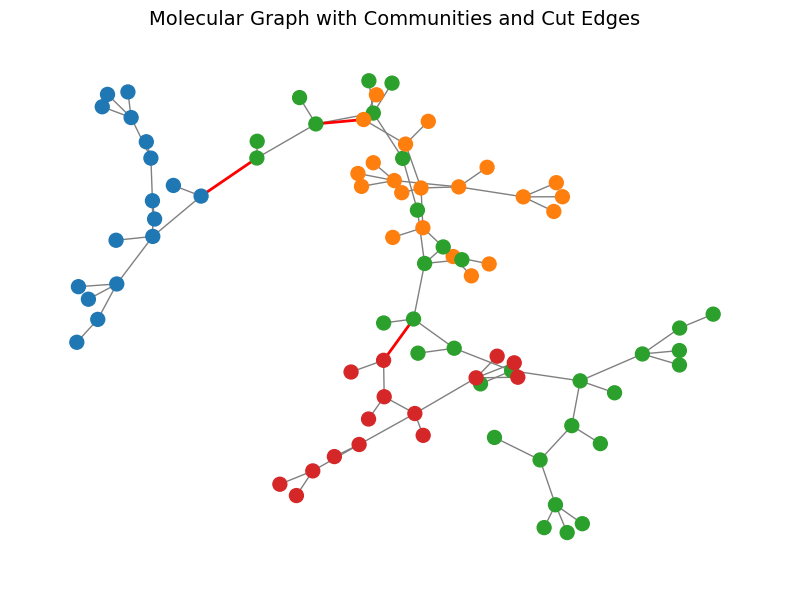

In [ ]:
#! pip install xyz2graph
#!pip install "numpy<2.0"
import matplotlib.pyplot as plt
from xyz2graph import MolGraph
from networkx.algorithms.community import louvain_communities, modularity
import networkx as nx

def MakeGraph(File_Path):
  mg = MolGraph()
  mg.read_xyz(File_Path)
  G = mg.to_networkx()
  return(G)

def best_louvain_partition(graph, num_trials=10):
    best_modularity = -1
    best_partition = None

    for seed in range(num_trials):
            partition = louvain_communities(graph,resolution=0.1, seed=seed)
            mod_score = modularity(graph, partition)
            if mod_score > best_modularity:
              best_partition = partition
    return best_partition


def visualisation(communities):
  node_to_comm = {}               # More storage but faster look up
  comm_id = 0
  for comm in communities:      # divives all nodes into communites
    for node in comm:
        node_to_comm[node] = comm_id
    comm_id += 1

  edges_to_cut = []
  edges_to_keep = []
  for u, v in Graph.edges():
    if node_to_comm[u] != node_to_comm[v]:    #If connects 2 clusters
        edges_to_cut.append((u, v))
    else:
        edges_to_keep.append((u, v))

  print("Edges to cut between communities:",edges_to_cut)

  num_comms = len(communities)
  colors = plt.cm.tab10.colors  # up to 10 distinct colors
  node_colors = [colors[node_to_comm[n] % len(colors)] for n in Graph.nodes()]

  plt.figure(figsize=(8, 6))
  pos = nx.spring_layout(Graph, seed=42)  # position nodes with spring layout
  nx.draw_networkx_nodes(Graph, pos, node_color=node_colors, node_size=100)
  nx.draw_networkx_edges(Graph, pos, edgelist=edges_to_keep, edge_color='gray')
  nx.draw_networkx_edges(Graph, pos, edgelist=edges_to_cut, edge_color='red', width=2) #funky at times

  plt.title("Molecular Graph with Communities and Cut Edges", fontsize=14)
  plt.axis('off')
  plt.tight_layout()
  plt.show()



File_Path = "/content/4d2g_2.xyz"          # Used to make graph
Graph = MakeGraph(File_Path)

communities = best_louvain_partition(Graph)
visualisation(communities)


In [ ]:
'''
################################################################################

This is method doesn't get us a lot of funtionality to easily get the cut edges
and basic partition structure.

Plan to only use the above 2 for this now

################################################################################
'''
#!pip install communities
#!pip install networkx==2.8.8
#!pip install xyz2graph


import numpy as np
from xyz2graph import MolGraph
from networkx import adjacency_matrix
from communities.algorithms import louvain_method
from communities.algorithms import louvain_method
from communities.visualization import draw_communities


def MakeAdjecencyMatrix(File_Path):
  mg = MolGraph()
  mg.read_xyz(File_Path)
  G = mg.to_networkx()
  A = adjacency_matrix(G)
  return(A.toarray())                   # Provides a Adj_Matrix to work with

def get_partition(communites,frames):
  best_q = float('-inf')
  best_index = -1

  for i in range(len(frames)):
      q = float(frames[i].get('Q', float('-inf')))
      if q > best_q:
          best_q = q
          best_index = i

  Communities ={}
  C_list = frames[best_index]['C']
  for i in range(len(C_list)):
    comm = C_list[i]
    if comm not in Communities:
        Communities[comm] = []
    Communities[comm].append(i)
  return Communities



File_Path = "/content/TRP_HIS_TRP_1.xyz"          # Used to make graph
Matrix = MakeAdjecencyMatrix(File_Path)       # Recieves Adj_Matrix from xyz file
communities, frames = louvain_method(Matrix)
#draw_communities(Matrix, communities)
Partitions = get_partition(communities,frames)
print (Partitions)


/tmp/ipython-input-1-4180901916.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = adjacency_matrix(G)


{7: [0, 1, 2, 3, 4, 5], 29: [6, 7, 8, 9, 10, 11, 12], 15: [13, 14, 15, 16, 17, 18, 27], 26: [19, 20, 21, 22, 23, 24, 25, 26], 38: [28, 29, 30, 31, 32, 33, 34, 35, 36], 42: [37, 38, 39, 40, 41, 42, 43, 44], 55: [45, 46, 47, 48, 49, 50, 51, 52, 53], 56: [54, 55, 56, 57, 58, 59, 68], 67: [60, 61, 62, 63, 64, 65, 66, 67], 70: [69, 70, 71, 72, 73]}
